In [39]:
import time, sys, joblib

import pandas as pd

sys.path.append('/home/yilingh/SI-Interaction')
from selectinf.Simulation.plotting_helpers import *
from selectinf.Simulation.H1.nonlinear_H1_helpers import *

In [40]:
from operator import le, ge
def filter_pval_dict_new(target_dict, threshold=0.05, operator=le, p_flag="pivot"):
    grouped_targets = pd.DataFrame(target_dict).groupby(['parameter', 'method'])
    filtered_dict = {}
    # Filter by 
    for name, group in grouped_targets:
        # Subset the selected targets
        selected_targets_id = operator(np.abs(group['target']), threshold)
        selected_targets = group[p_flag][selected_targets_id]
        # Then filtered_dict.keys must be a dictionary
        if name[0] in filtered_dict.keys():
            filtered_dict[name[0]][name[1]] = selected_targets.tolist()
        else:
            filtered_dict[name[0]] = {}
            filtered_dict[name[0]][name[1]] = selected_targets.tolist()
        
    return filtered_dict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_MSE(oper_char):
    specific_method = "MLE"  # Replace with the name of your method
    
    # Create a modified DataFrame
    df_modified = oper_char.copy()
    
    # For the specific method, keep "tau" values separate
    # For other methods, set "tau" to a single category, e.g., "All"
    df_modified['prop'] = df_modified.apply(
        lambda row: row['prop'] if row['method'] == specific_method else 'Naive/DS', axis=1
    )
    
    # Plotting
    sns.boxplot(x='method', y='MSE', hue='prop', data=df_modified, showmeans=True)
    plt.xlabel("Method")
    plt.ylabel("MSE")
    plt.title("Boxplot of MSE by Method and prop")
    plt.show()


In [41]:
def combine_dicts(dict, new_dict):
    for key in dict.keys():
        dict[key] = dict[key] + new_dict[key]
        
    return dict

In [42]:
def combine_nested_dicts(dict, new_dict):
    combined_dict = {}
    for key in dict.keys():
        combined_dict[key] = combine_dicts(dict[key], new_dict[key])
    
    return combined_dict

# Vary sparsity with weak Hierarchy

In [43]:
n_task_per_file = 25
n_files = 10
base_dir = "vary_sparsity_"
files_list = []
for i in range(n_files):
    dir = base_dir + str(i*n_task_per_file) + "_"  + str((i+1)*n_task_per_file) + ".pkl"
    files_list.append(dir)

In [44]:
oper_char_full = None
ds_rank_def_count_full = None
target_dict_full = None
pval_dict_full = None
MSE_dict_full = None
F1_dict_full = None

for path in files_list:
    ds_rank_def_count, target_dict, pval_dict, MSE_dict, oper_char, F1_dict\
        = joblib.load(path)
    # Combine ds_rank_def_count
    if not ds_rank_def_count_full:
        ds_rank_def_count_full = ds_rank_def_count
    else:
        ds_rank_def_count_full = combine_dicts(ds_rank_def_count_full, ds_rank_def_count)
    # Combine target_dict
    if not target_dict_full:
        target_dict_full = target_dict
    else:
        target_dict_full = combine_dicts(target_dict_full, target_dict)
    if not pval_dict_full:
        pval_dict_full = pval_dict
    else:
        pval_dict_full = combine_nested_dicts(pval_dict_full, pval_dict)
    # Combine MSE_dict
    if not MSE_dict_full:
        MSE_dict_full = MSE_dict
    else:
        MSE_dict_full = combine_dicts(MSE_dict_full, MSE_dict)
    # Combine oper_char
    if not oper_char_full:
        oper_char_full = oper_char
    else:
        oper_char_full = combine_dicts(oper_char_full, oper_char)
    if not F1_dict_full:
        F1_dict_full = F1_dict
    else:
        F1_dict_full = combine_dicts(F1_dict_full, F1_dict)

In [45]:
ds_rank_def_count_full

{5: 134, 10: 228, 15: 249, 20: 250}

In [46]:
pd.DataFrame(oper_char_full).groupby(["method", "size"]).nunique()

coverage rate  avg length  prop  signal  main signal  \
method         size                                                         
Data Splitting 5                62         116     1       1            1   
               10               18          22     1       1            1   
               15                1           1     1       1            1   
MLE            5               121         250     1       1            1   
               10              132         250     1       1            1   
               15              130         250     1       1            1   
               20              110         250     1       1            1   
Naive          5               155         250     1       1            1   
               10              148         250     1       1            1   
               15              138         250     1       1            1   
               20              137         250     1       1            1   

                     target  power  
method         size                 
Data Splitting 5        116     76  
               10        22     19  
               15         1      1  
MLE            5        250    172  
               10       250    180  
               15       250    185  
               20       250    175  
Naive          5        250    128  
               10       250    134  
               15       250    148  
               20       250    129

ValueError: max() arg is an empty sequence

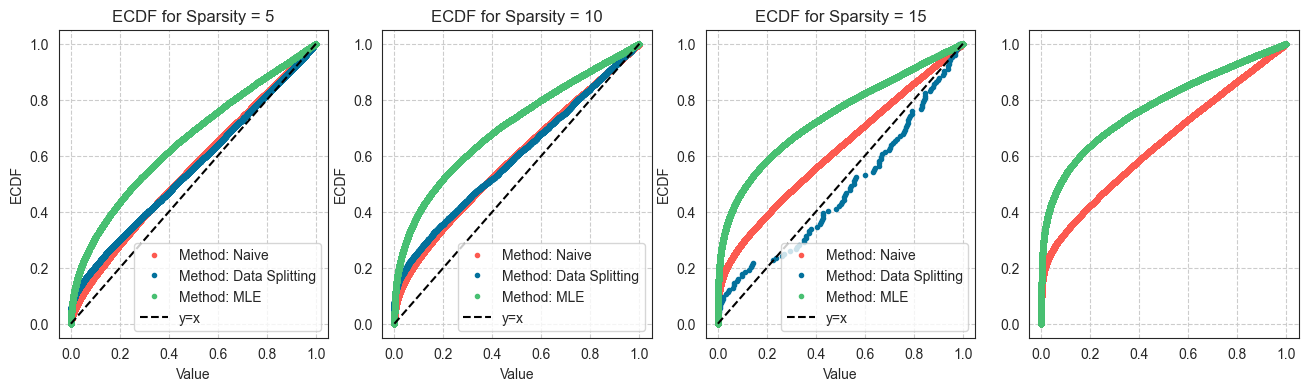

In [47]:
plot_ecdfs(pval_dict_full, xaxis="Sparsity")

In [48]:
## Plotting dict: SNR - Method - List of pvals
filtered_dict = filter_pval_dict_new(target_dict, threshold = 0,
                                     operator=ge)

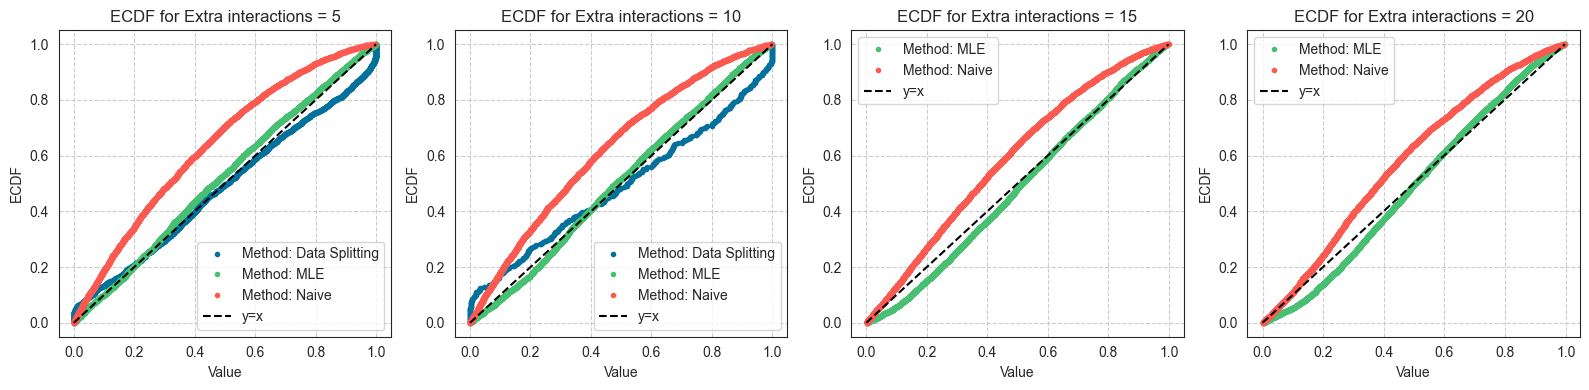

In [49]:
plot_ecdfs(filtered_dict, xaxis="Extra interactions")

In [50]:
my_palette = {"MLE": "#48c072",
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}
sns.set_style("white", {'axes.facecolor': 'white',
                            'axes.grid': True,
                            'axes.linewidth': 2.0,
                            'grid.linestyle': u'--',
                            'grid.linewidth': 4.0,
                            'xtick.major.size': 5.0,
                            })

Text(0, 0.5, 'Average Length')

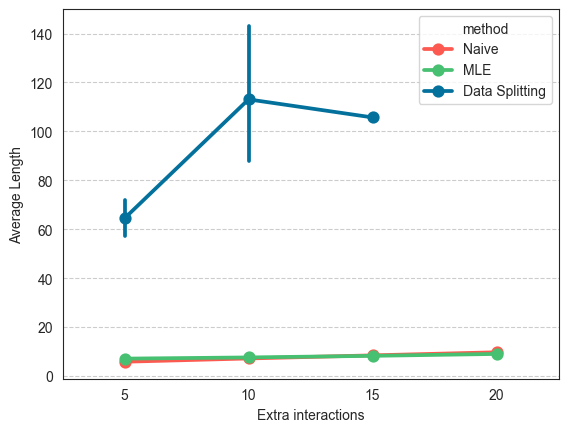

In [51]:
sns.pointplot(x=pd.DataFrame(oper_char_full)["size"],
              y=pd.DataFrame(oper_char_full)["avg length"],
              hue=pd.DataFrame(oper_char_full)["method"], markers='o',
              palette=my_palette)
#plt.ylim(10,35)
plt.xlabel(r"Extra interactions")
plt.ylabel("Average Length")

Text(0, 0.5, 'Test MSE')

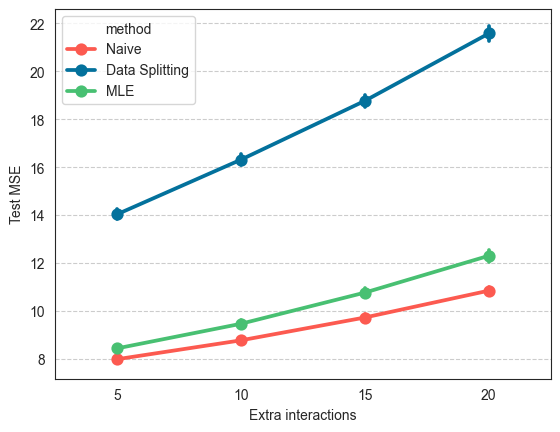

In [52]:
sns.pointplot(x=pd.DataFrame(MSE_dict_full)["size"],
              y=pd.DataFrame(MSE_dict_full)["MSE"],
              hue=pd.DataFrame(MSE_dict_full)["method"], markers='o',
              palette=my_palette)
#plt.ylim(25,30)
plt.xlabel("Extra interactions")
plt.ylabel("Test MSE")

Text(0, 0.5, 'F1 score')

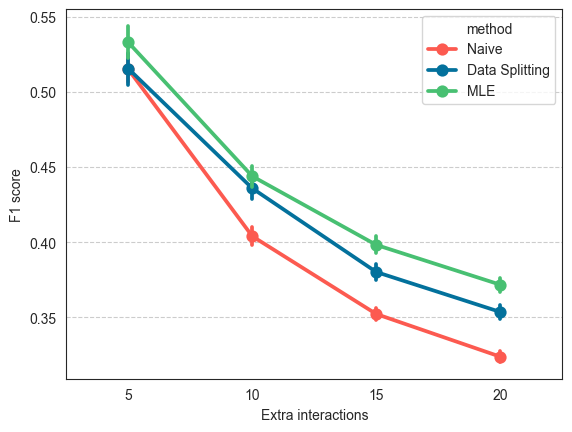

In [53]:
sns.pointplot(x=pd.DataFrame(F1_dict_full)["size"],
              y=pd.DataFrame(F1_dict_full)["F1"],
              hue=pd.DataFrame(F1_dict_full)["method"], markers='o',
              palette=my_palette)
#plt.ylim(25,30)
plt.xlabel("Extra interactions")
plt.ylabel("F1 score")

# Applying BY Correction to the p-values

In [54]:
from collections import defaultdict
from scipy.stats import false_discovery_control


def add_BY_pval_by_method_and_index(data):
    # Check if BYpval is there
    if "BYpval" in data.keys():
        return
    # Assuming your dictionary is named 'data' and structured as described
    methods = data['method']
    indices = data['index']
    pvals = data['pval']

    # Initialize default dictionaries to collect p-values and positions for each (method, index) pair
    pvals_dict = defaultdict(list)
    pos_dict = defaultdict(list)

    # Iterate over the data and populate the dictionaries
    for i, (method, index, pval) in enumerate(zip(methods, indices, pvals)):
        key = (method, index)
        pvals_dict[key].append(pval)
        pos_dict[key].append(i)

    # Initialize BYpvals array with the same length as pvals
    BYpvals = [0] * len(pvals)  # or use numpy.zeros_like(pvals) if pvals is a numpy array

    # Apply BY correction and assign back to positions
    for key in pvals_dict:
        pvals_list = pvals_dict[key]
        positions = pos_dict[key]
        corrected_pvals = false_discovery_control(pvals_list, method='by')
        for pos, by_pval in zip(positions, corrected_pvals):
            BYpvals[pos] = by_pval

    # Add BYpvals to the original data dictionary
    data['BYpvals'] = BYpvals

    # Now, pvals_dict contains lists of p-values for each unique (method, index) pair

In [55]:
add_BY_pval_by_method_and_index(target_dict_full)

# Calculating Thresholded Power

In [56]:
def calculate_thresholded_power(pvalue, targets, level, threshold=0.05,
                                operator=ge):
    pvalue = np.array(pvalue)
    targets = np.array(targets)
    non_null = operator(np.abs(targets), threshold)
    rejection = pvalue < level
    if np.sum(non_null) == 0 or np.sum(rejection) == 0:
        return 0
    else:
        if operator == ge:
            # non_null: non-null
            true_rej = np.sum(non_null * rejection) / np.sum(non_null)
        else:
            # non_null: actually null
            true_rej = np.sum(non_null * rejection) / np.sum(rejection)

    return true_rej

def calculate_thresholded_power_df(targets_dict,
                                   threshold=0.1,
                                   level=0.1,
                                   operator=ge, 
                                   pval_key = "BYpvals"):
    grouped_targets = pd.DataFrame(targets_dict).groupby(['index',
                                                          'method', 'parameter'])
    power_df = {}
    power_df['parameter'] = []
    power_df['method'] = []
    power_df['thresholded power'] = []
    for name, group in grouped_targets:
        power_df['parameter'].append(name[2])
        power_df['method'].append(name[1])
        pvalues = group[pval_key]
        targets = group['target']
        power_df['thresholded power'].append(
            calculate_thresholded_power(pvalues, targets, level=level, 
                                        threshold=threshold, operator=operator))
    return power_df

In [57]:
def point_plot_power(oper_char_dfs, x_axis='p', hue='method', 
                     ylim_low=None, ylim_high=None, exclude_naive=True,
                     randomizer_scales=None, x_label=None):
    for i in range(len(oper_char_dfs)):
        oper_char_dfs[i] = oper_char_dfs[i].copy()
        if exclude_naive:
            oper_char_dfs[i] = oper_char_dfs[i][oper_char_dfs[i]['method'] != "Naive"]
    sns.set_style("white", {'axes.facecolor': 'white',
                            'axes.grid': True,
                            'axes.linewidth': 2.0,
                            'grid.linestyle': u'--',
                            'grid.linewidth': 4.0,
                            'xtick.major.size': 5.0,
                            })
    # sns.histplot(oper_char_df["sparsity size"])
    # plt.show()
    n_subplots = len(oper_char_dfs)
    # cols = int(np.ceil(n_subplots / 2))
    cols = n_subplots

    fig = plt.figure(figsize=(cols * 5, 6))

    my_palette = {"MLE": "#48c072",
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}

    # Create each subplot
    for i in range(1, n_subplots + 1):
        # ax = fig.add_subplot(2, cols, i) #two rows
        ax = fig.add_subplot(1, cols, i)  # one row
        if hue is not None:
            sns.pointplot(x=oper_char_dfs[i-1][x_axis],
                          y=oper_char_dfs[i-1]['thresholded power'],
                          hue=oper_char_dfs[i-1][hue],
                          markers='o',
                          palette=my_palette,
                          ax=ax)
            ax.set_title("Randomizer Scale:" + str(randomizer_scales[i-1]))
        else:
            sns.pointplot(x=oper_char_dfs[i-1][x_axis],
                          y=oper_char_dfs[i-1]['thresholded power'],
                          markers='o',
                          palette=my_palette,
                          ax=ax)
        if ylim_low is not None and ylim_high is not None:
            ax.set_ylim([ylim_low, ylim_high])

        ax.legend().set_visible(False)

    handles, labels = ax.get_legend_handles_labels()
    # fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.2)

    fig.subplots_adjust(bottom=0.3)
    fig.legend(handles, labels, loc='lower center', ncol=n_subplots,
               prop={'size': 15})

    # cov_plot.legend_.remove()
    # len_plot.legend_.remove()

    # plt.suptitle("Changing n,p")
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    if x_label is not None:
        plt.xlabel(x_label)
    plt.show()

In [ ]:
power_threshold = 1
power_df1 = calculate_thresholded_power_df(targets_dict=target_dict_full, 
                                           threshold=power_threshold, level=0.1,
                                           operator=ge, pval_key="BYpvals")

In [ ]:
my_palette = {"MLE": "#48c072",
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}

In [ ]:
df = pd.DataFrame(power_df1)
#df = df[df["method"] != "Naive"]
sns.pointplot(x=df["parameter"],
              y=df["thresholded power"],
              hue=df["method"], markers='o',
              palette=my_palette)
plt.xlabel("Extra interactions")
plt.ylabel("Thresholded Power")

In [ ]:
power_threshold = 1
FDP_df1 = calculate_thresholded_power_df(targets_dict=target_dict_full,
                                           threshold=power_threshold, level=0.1,
                                           operator=le, pval_key="BYpvals")
sns.pointplot(x=FDP_df1["parameter"],
              y=FDP_df1["thresholded power"],
              hue=FDP_df1["method"], markers='o',
              palette=my_palette)
plt.xlabel("Extra interactions")
plt.ylabel("FDP")

# Power and FDP without Correction

In [10]:
power_threshold = 1
power_df1_noBY = calculate_thresholded_power_df(targets_dict=target_dict_full, 
                                           threshold=power_threshold, level=0.1,
                                           operator=ge, pval_key="pval")

NameError: name 'calculate_thresholded_power_df' is not defined

In [24]:
my_palette = {"MLE": "#48c072",
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}

Text(0, 0.5, 'Thresholded Power')

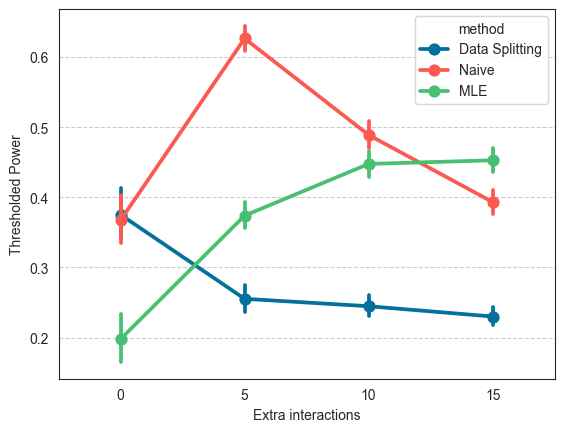

In [25]:
df = pd.DataFrame(power_df1_noBY)
#df = df[df["method"] != "Naive"]
sns.pointplot(x=df["parameter"],
              y=df["thresholded power"],
              hue=df["method"], markers='o',
              palette=my_palette)
plt.xlabel("Extra interactions")
plt.ylabel("Thresholded Power")

Text(0, 0.5, 'FDP')

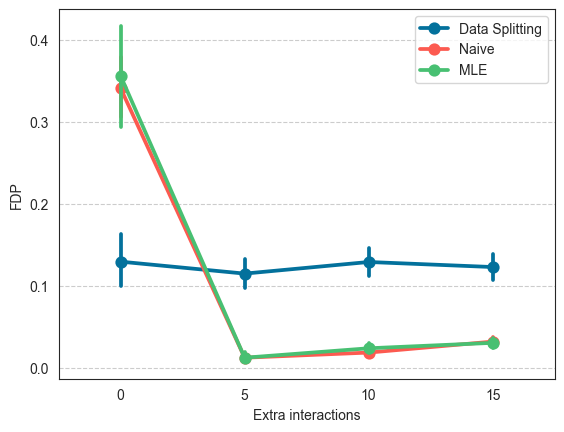

In [26]:
power_threshold = 1
FDP_df1_noBY = calculate_thresholded_power_df(targets_dict=target_dict_full,
                                           threshold=power_threshold, level=0.1,
                                           operator=le, pval_key="pval")
sns.pointplot(x=FDP_df1_noBY["parameter"],
              y=FDP_df1_noBY["thresholded power"],
              hue=FDP_df1_noBY["method"], markers='o',
              palette=my_palette)
plt.xlabel("Extra interactions")
plt.ylabel("FDP")

In [27]:
def power_plot(target_dict=None, thresholds=np.array(range(1,11))*0.1, level=0.1, 
               pval_key="pval", show=True,
               parameter_name='parameter', operator=ge, ylim=None):
    yaxis_name_dict = {("pval", ge): "Power (non-BY)",
                       ("pval", le): "FDP (non-BY)",
                       ("BYpvals", ge): "Power (BY)",
                       ("BYpvals", le): "FDP (BY)",}
    # Collect the data for each threshold
    df_list = []
    for t in thresholds:
        df_t = calculate_thresholded_power_df(targets_dict=target_dict,
                                              threshold=t, level=level,
                                              operator=operator, pval_key=pval_key)     # compute power(t) -> DataFrame
        df_t = pd.DataFrame(df_t).copy()                      # so we can safely modify
        df_t['threshold'] = t                   # store which threshold was used
        df_list.append(df_t)

    # Concatenate all thresholded results
    df_all = pd.concat(df_list, ignore_index=True)
    
    df_plot = (
        df_all
        .groupby(['parameter', 'method', 'threshold'], as_index=False)
        .agg({'thresholded power': 'mean'})
    )

    # --- 4) Create separate plots for each p ---
    figures = {}
    unique_ps = df_plot['parameter'].unique()
    
    # Create a figure with 1 row and len(unique_ps) columns
    n_p = len(unique_ps)
    fig, axes = plt.subplots(
        1, 
        n_p, 
        figsize=(3 * n_p, 4),   # width scales with number of p's
        sharey=True             # share y-axis if desired
    )
    
    # If there's only one p, axes is not a list by default, so make it a list
    if n_p == 1:
        axes = [axes]
    
    for i, par_val in enumerate(unique_ps):
        ax = axes[i]
        
        # Filter to only rows where p == p_val
        df_p = df_plot[df_plot['parameter'] == par_val]
        
        # Seaborn lineplot
        sns.lineplot(
            data=df_p,
            x='threshold',
            y='thresholded power',
            hue='method',
            palette=my_palette,
            marker='o',
            ax=ax
        )
        
        ax.set_title(f'{parameter_name} = {par_val}')
        ax.set_xlabel('Threshold (t)')
        if ylim:
            ax.set_ylim(0,ylim)
        if i == 0:
            ax.set_ylabel(yaxis_name_dict[(pval_key, operator)])
        else:
            ax.set_ylabel('')  # to avoid repeating "Power(t)" on every subplot if you like

        ax.grid(True)
        
        # Optionally, move the legend to the first subplot only,
        # or keep them all. For a single legend, you could do:
        # if i == 0:
        #     ax.legend()
        # else:
        #     ax.get_legend().remove()

    # Optional: tighten layout
    plt.tight_layout()

    # 6) Show or return
    if show:
        plt.show()

# Power plot for non-BY p-values

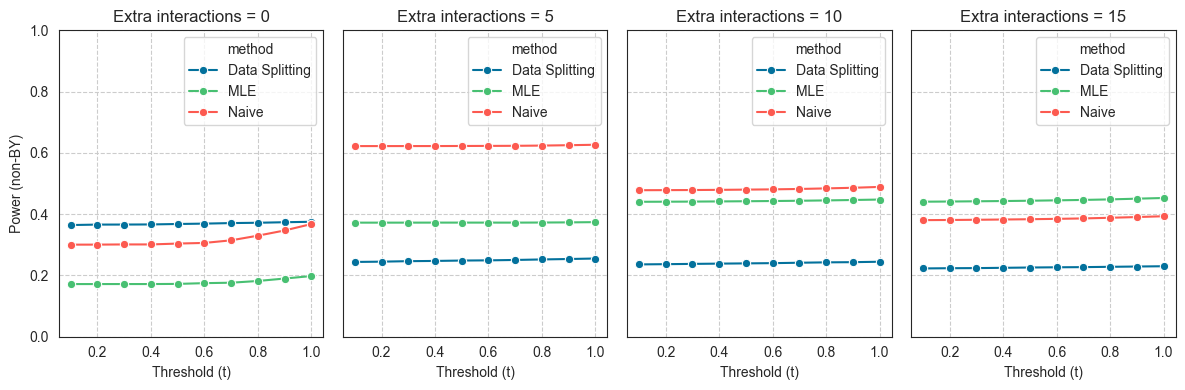

In [28]:
power_plot(target_dict=target_dict_full, pval_key="pval", parameter_name="Extra interactions", operator=ge, ylim = 1)

# FDP plot for non-BY p-values

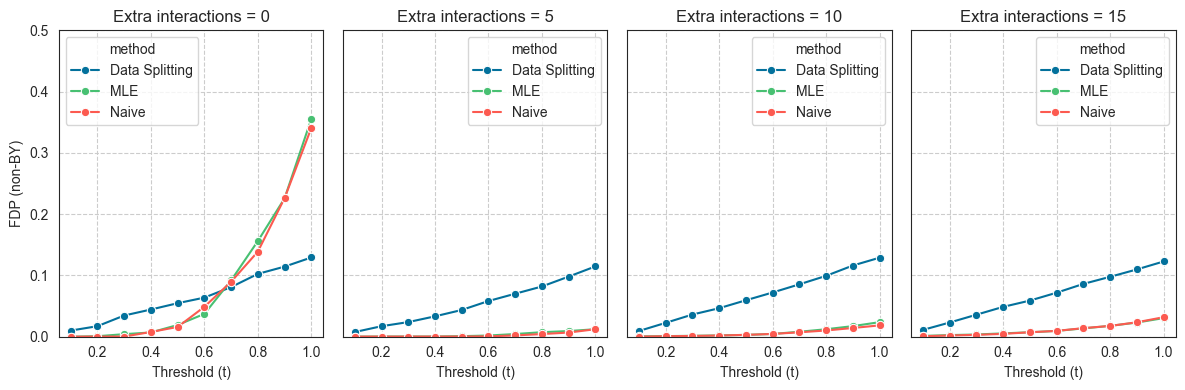

In [29]:
power_plot(target_dict=target_dict_full, pval_key="pval", parameter_name="Extra interactions", operator=le, ylim=0.5)

# Power plot for BY p-values

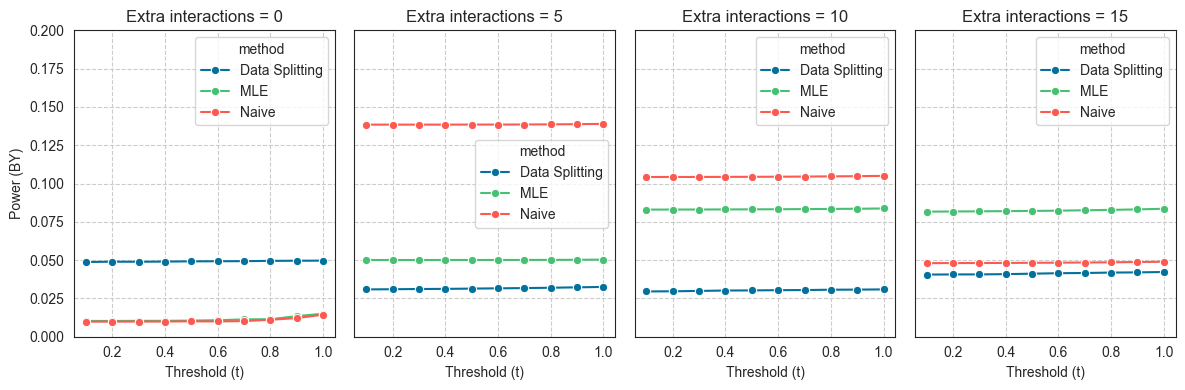

In [30]:
power_plot(target_dict=target_dict_full, pval_key="BYpvals", parameter_name="Extra interactions", operator=ge, ylim=.2)

# FDP for BY p-values

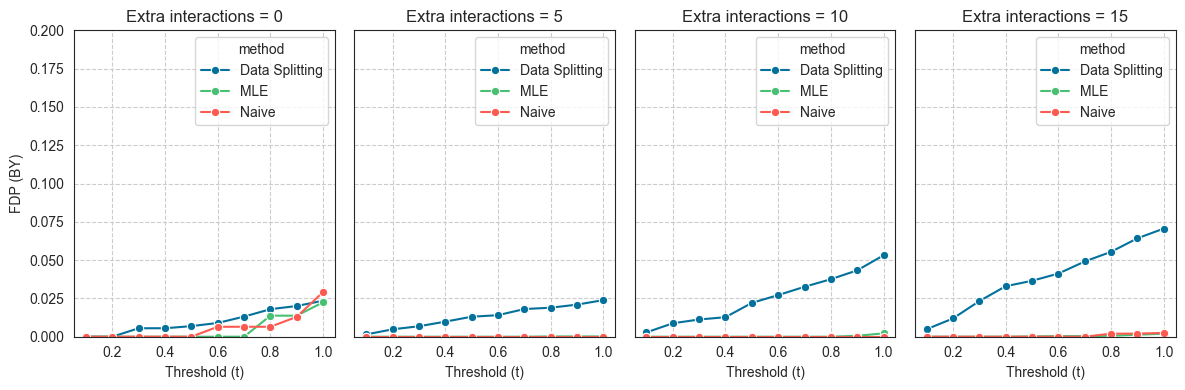

In [31]:
power_plot(target_dict=target_dict_full, pval_key="BYpvals", parameter_name="Extra interactions", operator=le, ylim=0.2)

# Check Number of True & False Rejections

In [58]:
def calculate_metrics(pvalue, targets, level, type, threshold=0.05):
    # Type = "Total", "Rej", "NonNull", "TP", "TN", "FP", "FN" 
    pvalue = np.array(pvalue)
    targets = np.array(targets)
    non_null = np.abs(targets) >= threshold
    rejection = pvalue < level
    null = np.abs(targets) < threshold
    acceptance = pvalue >= level
    TP = np.sum(non_null * rejection)
    FP = np.sum(null * rejection)
    TN = np.sum(null * acceptance)
    FN = np.sum(non_null * acceptance)
    
    prec = TP/(TP + FP) if (np.sum(rejection) > 0) else 0
    recall = TP/(TP + FN) if (TP + FN > 0) else 0
    FDR = FP/(TP + FP) if (np.sum(rejection) > 0) else 0
    FPR = FP/(FP + TN) if (FP + TN > 0) else 0
    def E(s, p):
        return -np.sqrt((1-2*p)**2/4-2*s)-(1-2*p)/2
    if type == "Prec":
        return prec
    if type == "Recall":
        return recall
    if type == "FDR":
        return FDR
    if type == "FPR":
        return FPR
    if type == "F1":
        return 2 * prec * recall / (prec + recall) if (prec * recall != 0) else 0
    if type == "N_rej":
        return np.sum(rejection)
        

def calculate_metric_df(targets_dict,
                          threshold=0.1,
                          level=0.1,
                          pval_key="pvals",
                        metric_list = ["Prec", "Recall", "FDR", "NonNull/Total"],
                        rank_def_count=None):
    grouped_targets = pd.DataFrame(targets_dict).groupby(['index',
                                                          'method', 'parameter'])
    power_df = {}
    power_df['parameter'] = []
    power_df['method'] = []
    """metric_list = ["Total", "Card", "Rej", "NonNull", 
                   "TP", "TN", "FP", "FN", "ZeroRej","NonNull/Total"]"""
    for met in metric_list:
        power_df[met] = []
        
    # fill in entries where data splitting is rank deficient
    #rank_def_metrics = {col: [] for col in power_df.keys()}
    for par in np.unique(targets_dict['parameter']):
        power_df['parameter'] += [par] * rank_def_count[par]
        power_df['method'] += ["Data Splitting"] * rank_def_count[par]
        for met in metric_list:
            power_df[met] += [0] * rank_def_count[par]
    
    for name, group in grouped_targets:
        power_df['parameter'].append(name[2])
        power_df['method'].append(name[1])
        pvalues = group[pval_key]
        targets = group['target']
        for met in metric_list:
            power_df[met].append(
                calculate_metrics(pvalues, targets, level=level,
                                  type=met, threshold=threshold)
            )
    
    return power_df

In [59]:
def metric_plot(target_dict=None, thresholds=np.array(range(1, 11)) * 0.02, level=0.1,
                pval_key="pval", 
                parameter_name='parameter', 
                metric_list=None,
                rank_def_count=None):
    
    # Collect the data for each threshold
    df_list = []
    for t in thresholds:
        df_t = calculate_metric_df(targets_dict=target_dict,
                                     threshold=t, level=level,
                                     pval_key=pval_key,
                                   metric_list=metric_list,
                                   rank_def_count=rank_def_count)  # compute power(t) -> DataFrame
        df_t = pd.DataFrame(df_t).copy()  # so we can safely modify
        df_t['threshold'] = t  # store which threshold was used
        df_list.append(df_t)

    # Concatenate all thresholded results
    df_all = pd.concat(df_list, ignore_index=True)

    df_plot = (
        df_all
        .groupby(['parameter', 'method', 'threshold'], as_index=False)
        .agg({metric: "mean" for metric in metric_list})
    )

    # --- 4) Create separate plots for each p ---
    figures = {}
    unique_ps = df_plot['parameter'].unique()
    
    def plot_one_metric(metric):
        # Create a figure with 1 row and len(unique_ps) columns
        n_p = len(unique_ps)
        fig, axes = plt.subplots(
            1,
            n_p,
            figsize=(3 * n_p, 4),  # width scales with number of p's
            sharey=True  # share y-axis if desired
        )
    
        # If there's only one p, axes is not a list by default, so make it a list
        if n_p == 1:
            axes = [axes]
    
        for i, par_val in enumerate(unique_ps):
            ax = axes[i]
    
            # Filter to only rows where p == p_val
            df_p = df_plot[df_plot['parameter'] == par_val]
    
            # Seaborn lineplot
            sns.lineplot(
                data=df_p,
                x='threshold',
                y=metric,
                hue='method',
                palette=my_palette,
                marker='o',
                ax=ax
            )
    
            ax.set_title(f'{parameter_name} = {par_val}')
            ax.set_xlabel('Threshold (t)')
            if i == 0:
                ax.set_ylabel(metric)
            else:
                ax.set_ylabel('')  # to avoid repeating "Power(t)" on every subplot if you like
    
            ax.grid(True)
    
            # Optionally, move the legend to the first subplot only,
            # or keep them all. For a single legend, you could do:
            # if i == 0:
            #     ax.legend()
            # else:
            #     ax.get_legend().remove()
    
        # Optional: tighten layout
        plt.tight_layout()
        
        plt.show()
        
    for metric in metric_list:
        plot_one_metric(metric)
    
    return df_list

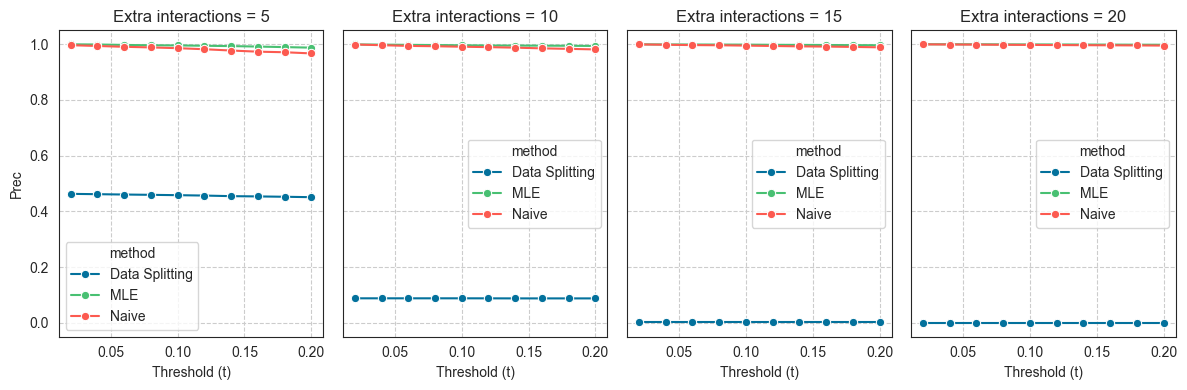

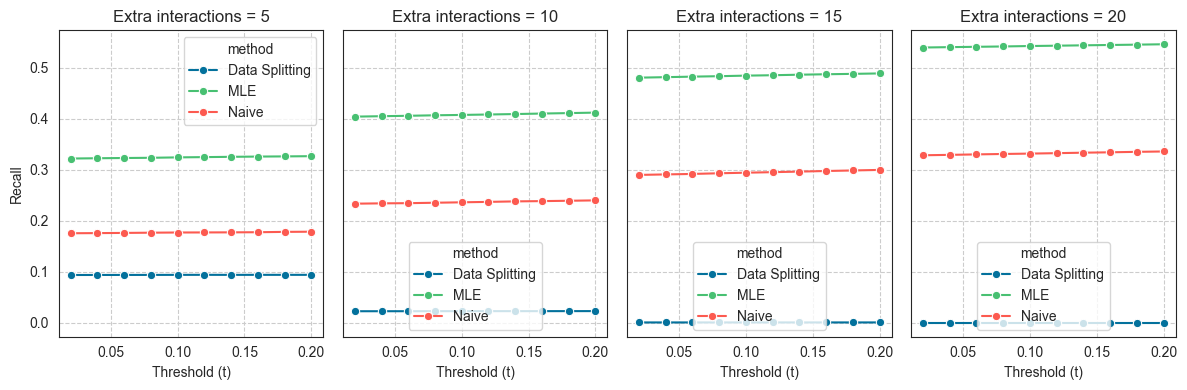

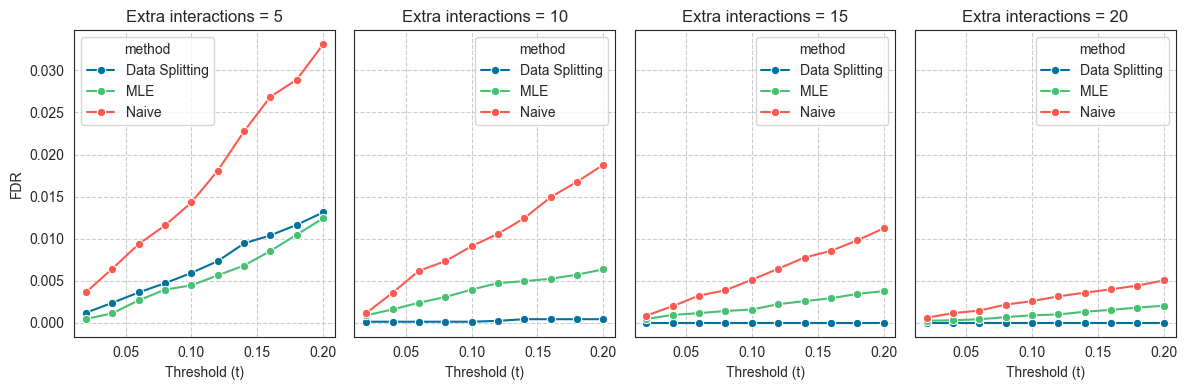

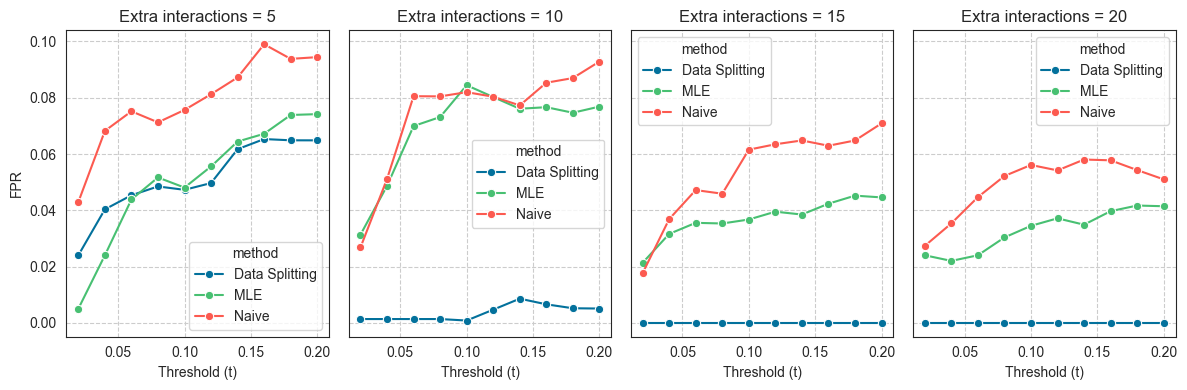

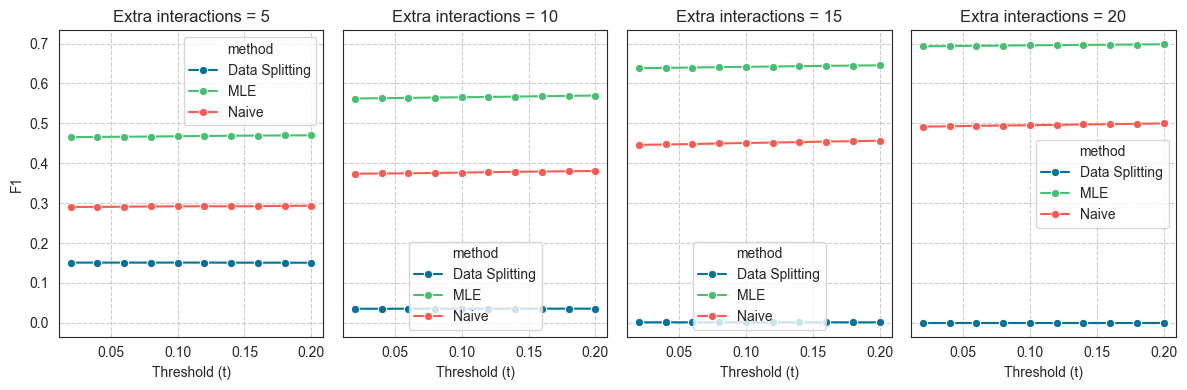

In [60]:
df_list = metric_plot(target_dict=target_dict_full, pval_key="pval",
            parameter_name="Extra interactions", 
            metric_list=["Prec", "Recall", "FDR", "FPR", "F1"],
                      rank_def_count=ds_rank_def_count_full)

In [61]:
ds_rank_def_count_full

{5: 134, 10: 228, 15: 249, 20: 250}

In [64]:
def metric_by_alpha_plot(target_dict=None, 
                         threshold=0.1, 
                         levels=np.arange(start=0, stop=0.5, step=0.05) + 0.05,
                pval_key="pval", 
                parameter_name='parameter', 
                metric_list=None,
                rank_def_count=ds_rank_def_count_full):
    
    # Collect the data for each threshold
    df_list = []
    for level in levels:
        df_t = calculate_metric_df(targets_dict=target_dict,
                                     threshold=threshold, level=level,
                                     pval_key=pval_key,
                                   metric_list=metric_list,
                                   rank_def_count=rank_def_count)  # compute power(t) -> DataFrame
        df_t = pd.DataFrame(df_t).copy()  # so we can safely modify
        df_t['alpha'] = level  # store which threshold was used
        df_list.append(df_t)

    # Concatenate all thresholded results
    df_all = pd.concat(df_list, ignore_index=True)

    df_plot = (
        df_all
        .groupby(['parameter', 'method', 'alpha'], as_index=False)
        .agg({metric: "mean" for metric in metric_list})
    )

    # --- 4) Create separate plots for each p ---
    figures = {}
    unique_ps = df_plot['parameter'].unique()
    
    def plot_one_metric(metric):
        # Create a figure with 1 row and len(unique_ps) columns
        n_p = len(unique_ps)
        fig, axes = plt.subplots(
            1,
            n_p,
            figsize=(3 * n_p, 4),  # width scales with number of p's
            sharey=True  # share y-axis if desired
        )
    
        # If there's only one p, axes is not a list by default, so make it a list
        if n_p == 1:
            axes = [axes]
    
        for i, par_val in enumerate(unique_ps):
            ax = axes[i]
    
            # Filter to only rows where p == p_val
            df_p = df_plot[df_plot['parameter'] == par_val]
    
            # Seaborn lineplot
            sns.lineplot(
                data=df_p,
                x='alpha',
                y=metric,
                hue='method',
                palette=my_palette,
                marker='o',
                ax=ax
            )
    
            ax.set_title(f'{parameter_name} = {par_val}')
            ax.set_xlabel(r"$\alpha$")
            if i == 0:
                ax.set_ylabel(metric)
            else:
                ax.set_ylabel('')  # to avoid repeating "Power(t)" on every subplot if you like
    
            ax.grid(True)
    
            # Optionally, move the legend to the first subplot only,
            # or keep them all. For a single legend, you could do:
            # if i == 0:
            #     ax.legend()
            # else:
            #     ax.get_legend().remove()
    
        # Optional: tighten layout
        plt.tight_layout()
        
        plt.show()
        
    for metric in metric_list:
        plot_one_metric(metric)
    
    return df_list

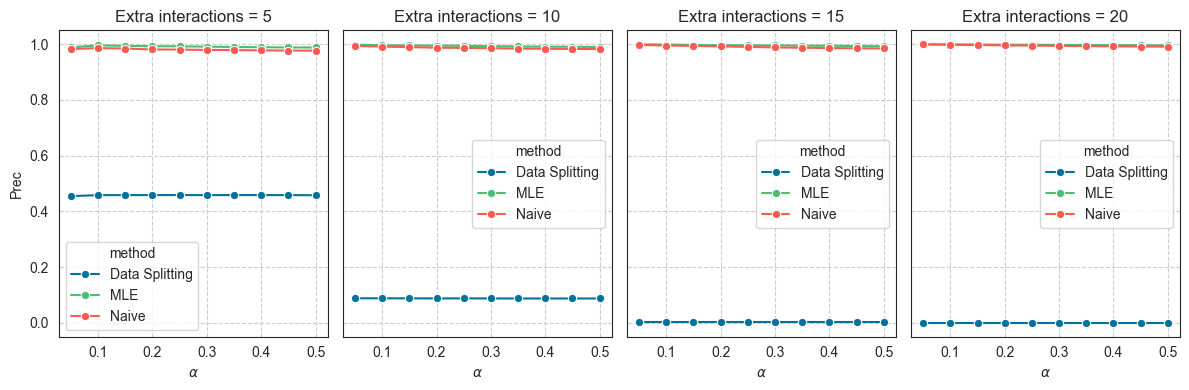

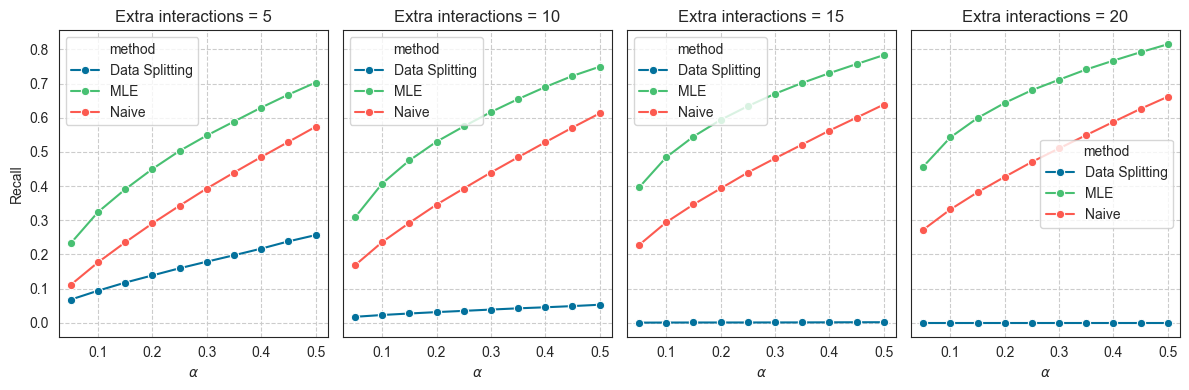

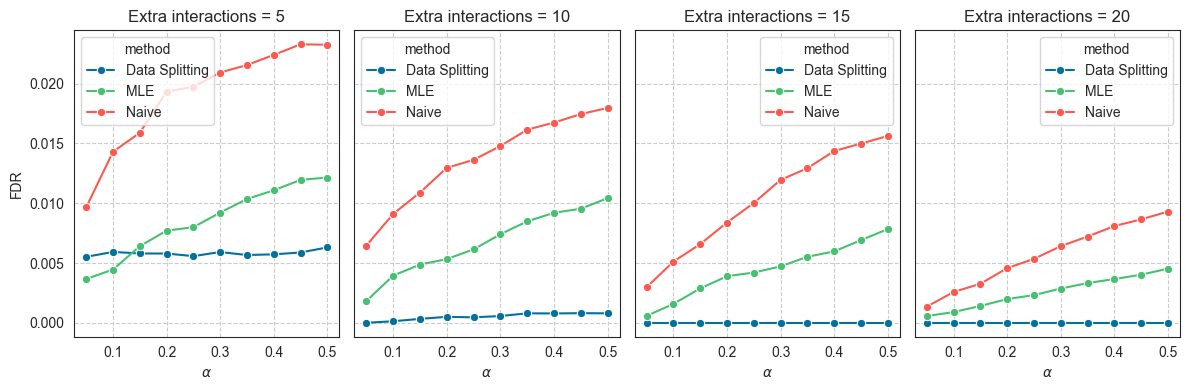

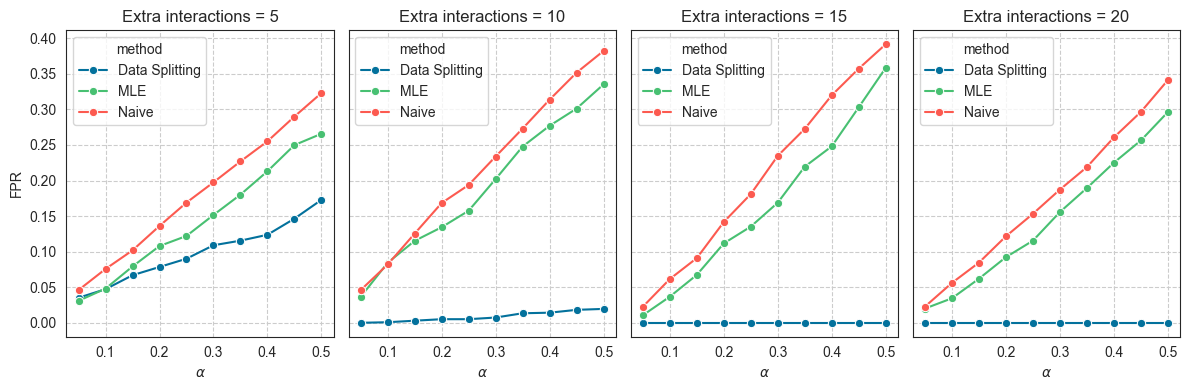

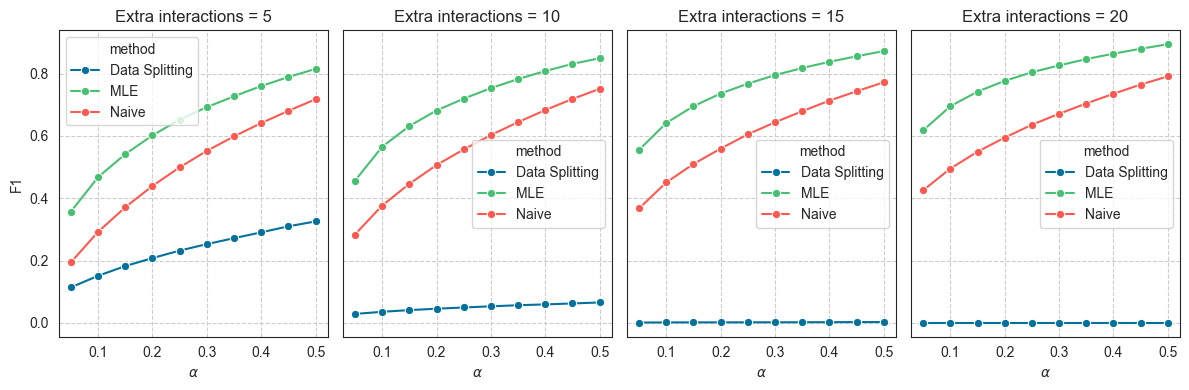

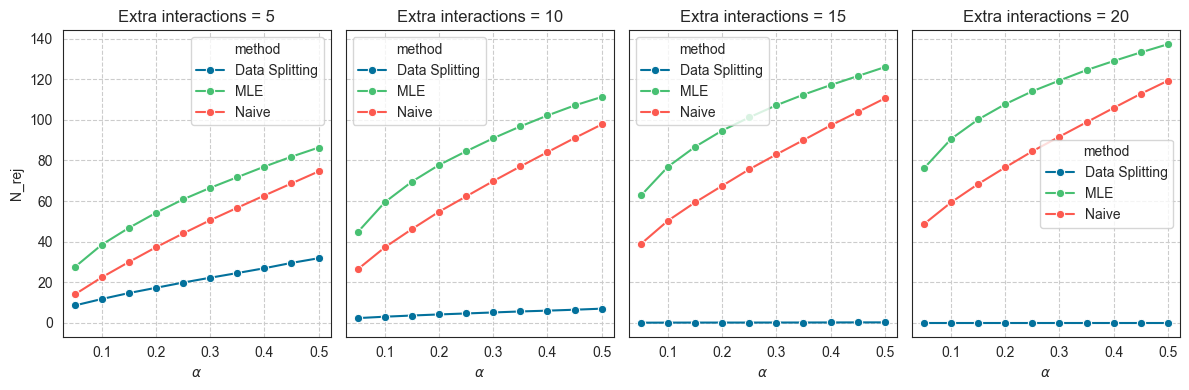

In [65]:
df_alpha = metric_by_alpha_plot(target_dict=target_dict_full, pval_key="pval",
                         parameter_name="Extra interactions", 
                         metric_list=["Prec", "Recall", "FDR", "FPR", "F1", "N_rej"],
                         rank_def_count=ds_rank_def_count_full)

In [75]:
# Concatenate all thresholded results
df_all = pd.concat(df_alpha, ignore_index=True)

df_plot = (
    df_all
    .groupby(['parameter', 'method', 'alpha'], as_index=False)
    .agg({metric: "mean" for metric in ["Prec", "Recall"]})
)

# --- 4) Create separate plots for each p ---
figures = {}
unique_ps = df_plot['parameter'].unique()

In [76]:
df_plot

,parameter,method,alpha,Prec,Recall
0,5,Data Splitting,0.05,0.454483,0.067993
1,5,Data Splitting,0.10,0.458074,0.093924
2,5,Data Splitting,0.15,0.458203,0.117649
3,5,Data Splitting,0.20,0.458208,0.138634
4,5,Data Splitting,0.25,0.458426,0.159565
...,...,...,...,...,...
115,20,Naive,0.30,0.993594,0.510177
116,20,Naive,0.35,0.992786,0.549121
117,20,Naive,0.40,0.991910,0.587760
118,20,Naive,0.45,0.991354,0.625946


In [77]:
def plot_precision_recall(df_plot, parameter_name):
        # Create a figure with 1 row and len(unique_ps) columns
        n_p = len(unique_ps)
        fig, axes = plt.subplots(
            1,
            n_p,
            figsize=(3 * n_p, 4),  # width scales with number of p's
            sharey=True  # share y-axis if desired
        )
    
        # If there's only one p, axes is not a list by default, so make it a list
        if n_p == 1:
            axes = [axes]
    
        for i, par_val in enumerate(unique_ps):
            ax = axes[i]
    
            # Filter to only rows where p == p_val
            df_p = df_plot[df_plot['parameter'] == par_val]
    
            # Seaborn lineplot
            sns.lineplot(
                data=df_p,
                x='Recall',
                y='Prec',
                hue='method',
                palette=my_palette,
                marker='o',
                ax=ax
            )
    
            ax.set_title(f'{parameter_name} = {par_val}')
            ax.set_xlabel("Recall")
            ax.set_ylabel("Precision")
            ax.set_xlim(0,1)
            ax.set_ylim(0,1.1)
            
    
            ax.grid(True)
    
            # Optionally, move the legend to the first subplot only,
            # or keep them all. For a single legend, you could do:
            # if i == 0:
            #     ax.legend()
            # else:
            #     ax.get_legend().remove()
    
        # Optional: tighten layout
        plt.tight_layout()
        
        plt.show()

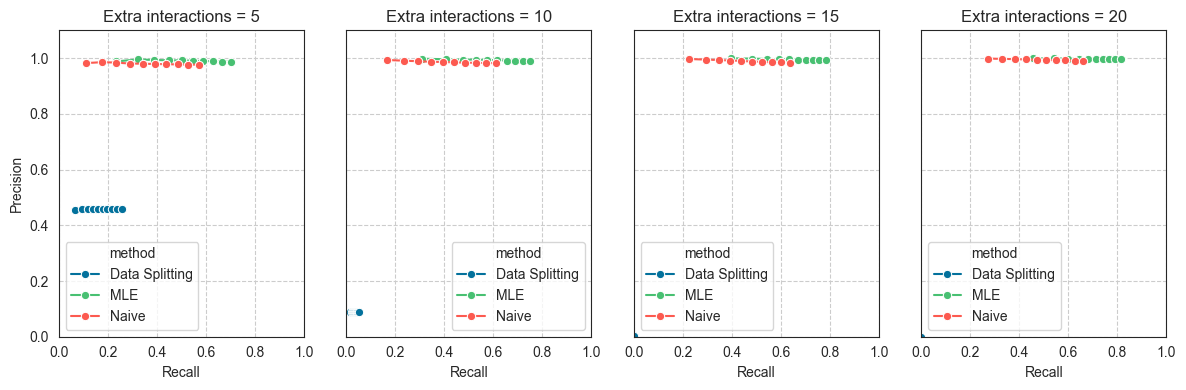

In [78]:
plot_precision_recall(df_plot, "Extra interactions")

In [28]:
import matplotlib.ticker as ticker
def metric_by_rejection_plot(target_dict=None, thresholds=np.array(range(1, 11)) * 0.02, level=0.1,
                pval_key="pval",
                parameter_name='parameter',
                metric_list=None,
                rank_def_count=None):
    # Collect the data for each threshold
    df = calculate_metric_df(targets_dict=target_dict,
                               threshold=0.1, level=level,
                               pval_key=pval_key,
                               metric_list=metric_list,
                               rank_def_count=rank_def_count)  # compute power(t) -> DataFrame
    df = pd.DataFrame(df).copy()  # so we can safely modify
    
    # Create bins for the number of rejections
    max_rej = df['N_rej'].max()
    bins = np.arange(0, max_rej + 20, 20)  # you can adjust the step size
    df['rejection_bin'] = pd.cut(df['N_rej'], bins=bins, include_lowest=True)

    df_plot = df
    
    """df_plot = (
        df
        .groupby(['parameter', 'method', 'N_rej'], as_index=False)
        .agg({metric: "mean" for metric in metric_list})
    )"""

    # --- 4) Create separate plots for each p ---
    figures = {}
    unique_ps = df_plot['parameter'].unique()

    def plot_one_metric(metric):
        # Create a figure with 1 row and len(unique_ps) columns
        n_p = len(unique_ps)
        fig, axes = plt.subplots(
            1,
            n_p,
            figsize=(3 * n_p, 4),  # width scales with number of p's
            sharey=True  # share y-axis if desired
        )

        # If there's only one p, axes is not a list by default, so make it a list
        if n_p == 1:
            axes = [axes]

        for i, par_val in enumerate(unique_ps):
            ax = axes[i]

            # Filter to only rows where p == p_val
            df_p = df_plot[df_plot['parameter'] == par_val]

            # Seaborn lineplot
            sns.boxplot(
                data=df_p,
                x='rejection_bin',
                y=metric,
                hue='method',
                palette=my_palette,
                #marker='o',
                showfliers=False,
                ax=ax
            )
            """
            
            #    Overlay raw data points with high transparency
            #    We'll use a "strip plot" or "swarm plot" to show individual points.
            sns.stripplot(
                data=df,
                x='N_rej',
                y=metric,
                hue='method',
                palette=my_palette,
                dodge=True,     # separate the points by 'method'
                alpha=0.05,      # transparency so points won't overwhelm the plot
                legend=False,    # don't create a second legend
                ax=ax,
                zorder=1
            )
            
            sns.lineplot(
                data=df,
                x='N_rej',
                y=metric,
                hue='method',
                palette=my_palette,
                estimator='mean',   # default is mean, but you can set e.g. np.median
                errorbar='sd',            # or None / 'sd' / 95, etc.
                legend='brief',
                ax=ax,
                linewidth=3,  # Increase thickness
                alpha=1.0,
                zorder=2
            )
            """
            ax.set_title(f'{parameter_name} = {par_val}')
            ax.set_xlabel('# Rejection')
            #ax.xaxis.set_major_locator(ticker.MaxNLocator(6))
            ax.tick_params(axis='x', labelrotation=45)
            if i == 0:
                ax.set_ylabel(metric)
            else:
                ax.set_ylabel('')  # to avoid repeating "Power(t)" on every subplot if you like

            ax.grid(True)

            # Optionally, move the legend to the first subplot only,
            # or keep them all. For a single legend, you could do:
            # if i == 0:
            #     ax.legend()
            # else:
            #     ax.get_legend().remove()

        # Optional: tighten layout
        plt.tight_layout()

        plt.show()

    for metric in metric_list:
        if metric == "N_rej":
            continue
        plot_one_metric(metric)

    return df_list

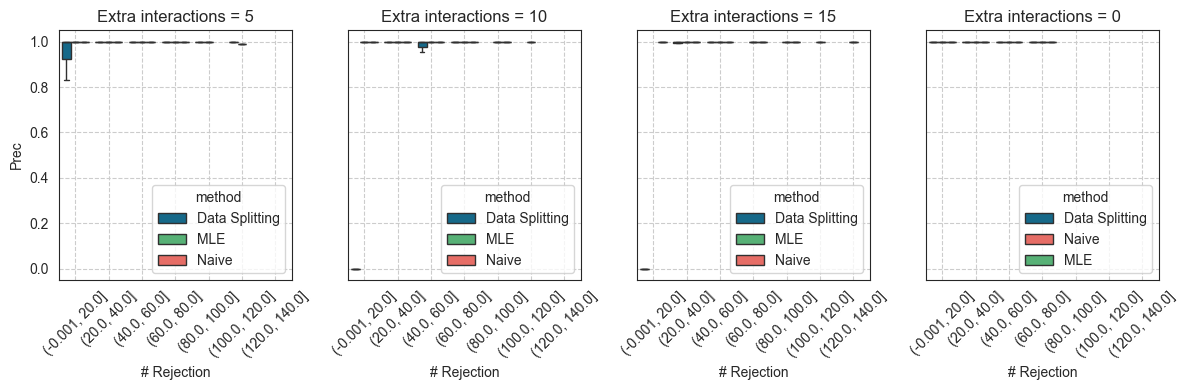

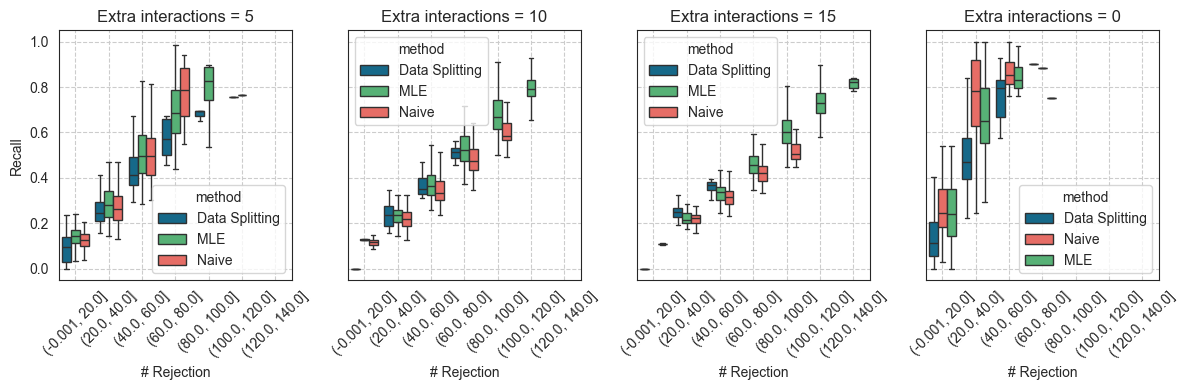

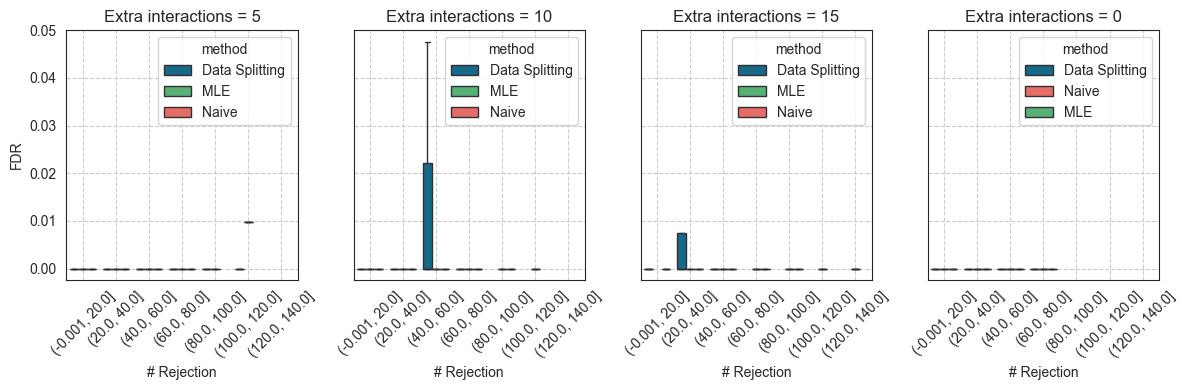

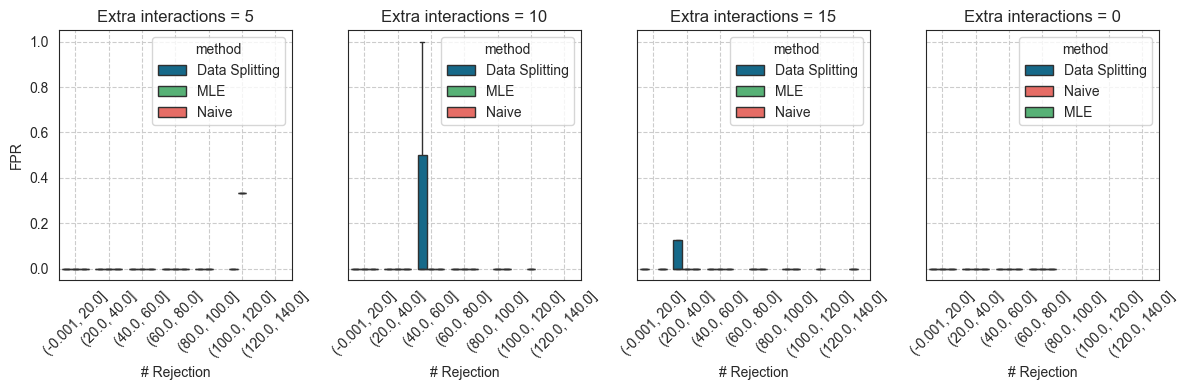

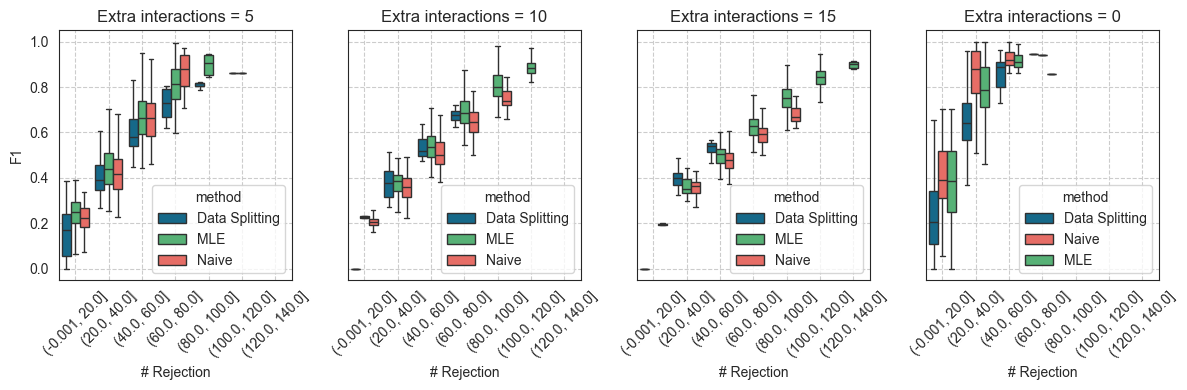

[       parameter          method  Prec    Recall  FDR  FPR        F1  \
 0              5  Data Splitting   0.0  0.000000  0.0  0.0  0.000000   
 1              5  Data Splitting   0.0  0.000000  0.0  0.0  0.000000   
 2              5  Data Splitting   0.0  0.000000  0.0  0.0  0.000000   
 3              5  Data Splitting   0.0  0.000000  0.0  0.0  0.000000   
 4              5  Data Splitting   0.0  0.000000  0.0  0.0  0.000000   
 ...          ...             ...   ...       ...  ...  ...       ...   
 11789         15             MLE   1.0  0.633929  0.0  0.0  0.775956   
 11790          0           Naive   1.0  0.162162  0.0  0.0  0.279070   
 11791          5           Naive   1.0  0.090909  0.0  0.0  0.166667   
 11792         10           Naive   1.0  0.080645  0.0  0.0  0.149254   
 11793         15           Naive   1.0  0.129870  0.0  0.0  0.229885   
 
        threshold  
 0           0.02  
 1           0.02  
 2           0.02  
 3           0.02  
 4           0.02  
 .

In [29]:
metric_by_rejection_plot(target_dict=target_dict_full, pval_key="pval",
                         parameter_name="Extra interactions", 
                         metric_list=["Prec", "Recall", "FDR", "FPR", "F1", "N_rej"],
                         rank_def_count=ds_rank_def_count_full)

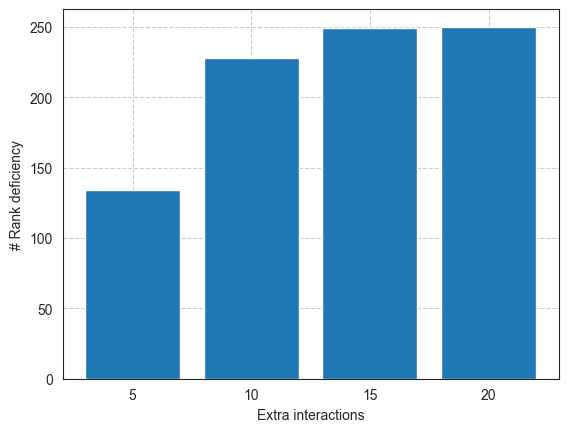

In [70]:
# Rank deficiency bar chart
D = ds_rank_def_count_full

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.xlabel("Extra interactions")
plt.ylabel("# Rank deficiency")

plt.show()